# Image Interpretation – Assignment 4

This assignment on Classification covers the labs from 24th and 31st October. The exercises on this sheet are graded by a maximum of 10 points. You will be asked to implement several functions and write a brief report.

In order to submit the results, send this ipynb file which should contain implemented functions and brief reports with all findings to <mikhail.usvyatsov@geod.baug.ethz.ch> with subject
[Image Interpretation 2019 Assignment 4]
no later than on the
6th of November, 2019.

Your functions should work when called by the provided test code (functions prefixed with `test` ) which must not be modified. When run, they should produce a plausible output, no warnings, and no unnecessary output. Eventual example output is given in the ref_-images. The functions that you write take images as arguments, not image filenames (i.e. do not use imread inside the functions). Your functions should not generate figures/plots themselves, the plots are generated by the test functions.

In addition to the functions, include a brief report explaining the structure of the code and the Python functions used. This includes the reasons for choosing particular functions as well as a short justification of their parameter setting. For the more complicated tasks, the choice of the underlying data structures and algorithms should be explained too. We encourage you to add also diagrams, illustrations, and figures into the report when appropriate, but it is not necessary to copy the related theory from the lecture slides. The code should contain comments if appropriate.

**Team work is not allowed**. Everybody implements his/her own code and writes his/her own report. Discussing issues with others is fine, sharing code and/or report with others is **not**. If you use any code fragments found on the Internet, make sure you reference them properly.

This exercise focuses on using classification methods, as
implementing most classifiers takes more time than is reasonable in the scope of
this assignment. The exception is the exercise about LDA, which is
simple enough to be done manually. The rest of the programming exercises are very
short.

As in the regression assignment, $Y$ stands for a column vector of "_target_" values, that is the $i$-th row of $Y$ contains the desired output for the $i$-th
data point. Contrary to regression, the elements of $Y$ are integer values. In
most exercises we use binary classifiers, where one class has the label $1$ and
the other class has the label $2$. 
$X$ is a matrix containing the feature values, where the $i$-th row contains
the values for the $i$-th data point.

The synthetic data are generated randomly for each run in the
"_toy example_" test functions, so you can run the functions multiple times to get
different outputs.

In your reports, comment on the performance of the individual
methods when applied on the aerial photo of Graz. Describe also the difference
between the results on data seen during training (the left quarter of the image) and
data that are "_new_" (the rest of the image). Does a given method work equally
well for every class?}
You can (and actually need to in order to generate the results for the report)
change the "_true_" class in the test functions that use binary
classification by changing the __true_class__ variable if you want to see
outputs for different classes. A value of $1$ represents streets, $2$ buildings, and
$3$ vegetation. A reference to this is given in function `untitled`.

You can also use more
features for classification (features from a lower scale) by employing function
ii_gaussian which you implemented in the second exercise (see the commented
lines with __create_features__ in the test functions).

In [288]:
def untitled():
    X_1 = X[Y == 1, :]

    # You can edit the test scripts if you 
    # want to see results for different classes 
    # change true_class value to
    # 1: streets
    # 2: buildings
    # 3: vegetation
    # You can also see test_lda2 to see how 
    # to use more features

# Problem 1, 1p

Nearest neighbour classification (especially its k-NN variant) is a simple
but yet quite powerful classification method which does not make any 
assumptions about the data model.

[Scikit-learn](http://scikit-learn.org/stable/) class http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html performing k-NN classification is demonstrated
in functions `demo_knn` (toy example) and `demo_knn2` (Graz aerial
photo). In the toy example, one can see the classification of red and blue points
into red and blue classes, respectively. Graz aerial photo example and the class
values for the second test have been explained in the introduction already.

Run the functions for different values of parameter $K$, $distance$ and $rule$ and comment the
results in your report. Also report the best parameters with explanation
why you think that they are the best.

In [289]:
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import cv2

from sklearn import metrics
from sklearn.model_selection import GridSearchCV 

%matplotlib inline

In [290]:
def synthetic_nonlin():
    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        
        return x, y

    n_samples = 100
    X_1 = np.random.randn(n_samples, 2) / 2
    
    a, b = pol2cart(np.random.rand(n_samples, 1) * 2 * np.pi, np.random.randn(n_samples, 1) / 3 + 1.5)
    X_2 = np.hstack([a, b])
    X = np.concatenate([X_1, X_2], axis=0)
    Y = np.concatenate([np.ones((n_samples)), 2 * np.ones((n_samples))]) - 1
    
    return X, Y

def decision_boundaries_vec(x_range, steps, classifier):
    l = np.linspace(x_range[0], x_range[1], steps)
    x, y = np.meshgrid(l, l)
    
    features = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=-1)
    
    if hasattr(classifier, 'predict'):
        return x, y, classifier.predict(features).reshape(x.shape)
    else:
        return x, y, classifier(features).reshape(x.shape)


def demo_knn():
    X, Y = synthetic_nonlin()
    classifier = KNeighborsClassifier(n_neighbors=3)
    classifier.fit(X, Y)

    x_range = np.array([X.min(), X.max()])

    x, y, decision_boundaries = decision_boundaries_vec(x_range, 1000, classifier)

    plt.figure(figsize=(10, 8))
    plt.contourf(x, y, decision_boundaries)
    plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c='r', marker='*')
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c='b', marker='o')
    plt.title('KNN (K=3)')


def load_graz(scale):
    img = cv2.imread('../data/graz_5.tif')
    gt = cv2.imread('../data/gt_graz_5.tif', 0)
    gt[gt == 4] = 3
    new_scale = tuple((np.array(img.shape) * scale).astype(np.int64))[:-1]

    return cv2.resize(img, new_scale), cv2.resize(gt, new_scale)


def create_features(varargin):
    sy, sx, nc = varargin.shape
    return varargin.reshape(sy * sx, nc)

    
def demo_knn2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 3

    Y = (gt == true_class) + 1

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)

#     classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
    
    # Newly added lines for cross-validation.
    estimator = KNeighborsClassifier()
    param_grid = {'n_neighbors': range(1,22,3),
                  'weights': ['uniform', 'distance'], 
                  'p': [1, 2]}
    clf_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
    clf_grid.fit(X, Y)
    
    print('Best hyperparameters for KNN:', clf_grid.best_params_)
    print('Best score:', clf_grid.best_score_)

    # Fit data with best hyperparameters.
    classifier = clf_grid.best_estimator_
    classifier.fit(X, Y)
    
    results_test = classifier.predict(X[used_train:sy * sx, :])
    results = np.concatenate([Y[:used_train], results_test]).reshape(sy, sx)
    
    print('Accuracy:', metrics.accuracy_score(Y, results.reshape(sy*sx))) # output accuracy

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title("Results")
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title("Original")

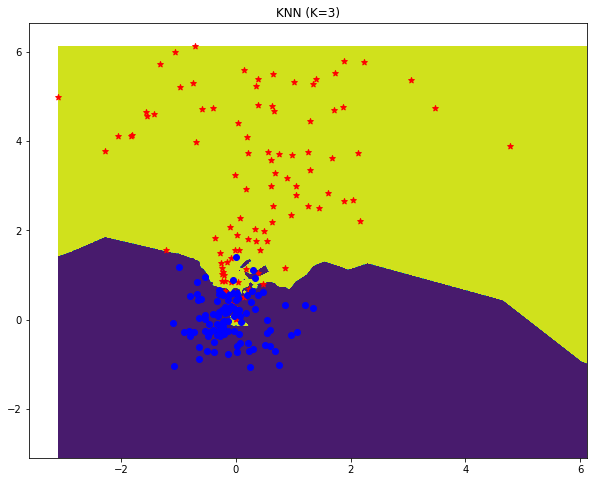

In [291]:
demo_knn()

Best hyperparameters for KNN: {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best score: 0.968804
Accuracy: 0.978452


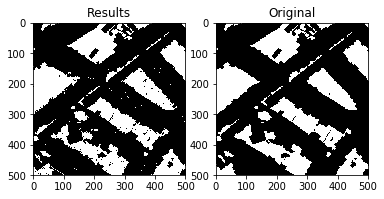

In [292]:
demo_knn2()

## Report - Part 1: k-Nearest Neighbors
**Run the functions for different values of parameter $K$, $distance$ and $rule$ and comment the results in your report. Also report the best parameters with explanation why you think that they are the best.**

With increasing $K$, more and more neighboring points are contributed to the vote of the center point. With small `K` value, the boundary would be not smooth. Another extreme is that all neighbors contribute to one result so that there is only one class output. We chose the range of `[1, 21] with interval=3` with The default weight is `uniform`, which treats all points in each neighborhood equally. Weight `distance` is tested in the experiment and it distributes weights by the inverse of the distance. Power parameter for the Minkowski metric `p` can change to different distance metric from default Euclidean distance with `p=2` to Manhattan distance when `p=1`.

To choose the best parameters for each type in the aerial photo of Graz, we used cross-validation to train the hyperparameters. In our task, cross-validation is implemented using function `GridSearchCV` to test all combinations of given `param_grid`. The best hyperparameters for street type are `K=16, p=1, weights='uniform'`. For buildings, they are `K=19, p=2, weights='uniform'`. And for vegetation, they are `K=19, p=1, weights='uniform'`.

The accuracy is introduced as the ratio of correct classification results. The accuracy of street type is `92.15%`. For buildings, it is `91.69%` and for vegetation, it is `97.85%`. KNN works well here. Among three types, it works best for vegetation type. Usually, the accuracy of the training data is higher than the test data since we use the training data to fit the function.

# Problem 2, 4p

LDA classifier can be used to efficiently classify linearly separable data.
Implement function `ii_train_lda` that trains an LDA classifier. The
input arguments are the training data (one row per sample and one column per
feature) and a column vector with the class labels of the samples (0
or 1). Return the normal $\theta$ of the decision boundary and the threshold
$t$ between classes (so that if $X\theta - t > 0$, class $1$ is predicted).
Since we use row vectors as features, the formulas are slightly different
from those seen in the lecture (but $\theta$ is still a column vector).

$m_1$ and $m_2$ are the means of the input features over all rows
where $Y$ is $0$ or $1$ respectively. You can calculate mean and covariance
for the classes with corresponding __numpy__ methods.
In order to do operations on the rows of $X$ where the corresponding row in $Y$
has a certain value (e.g.\ $1$), you can use the expression `X[Y==1,:]`.
Instead of determining $\theta$ by matrix inversion, which is numerically
unstable, use __numpy/scipy__ equation solving capabilities:


`normal = np.linalg.lstsq(SW, (m2-m1).T)[0]`


where SW is the sum of within-class covariances.
The threshold you output is the value of the projection at the point located
in the middle between the class means (the (dot) product of the mean of
$m_1$ and $m_2$ and the estimated normal).

The corresponding `test_lda` is already provided. You can use
functions `test_lda` and `test_lda2` to test your implementation and generate
results for the report.

In [293]:
def rotate_base(mat, ang):
    R = np.array([
        [np.cos(ang), np.sin(ang)],
        [-np.sin(ang), np.cos(ang)]
    ])
    
    return R.T.dot(mat).dot(R)


def mvarnormal(numelements, Sigma, mu):
    R = np.linalg.cholesky(Sigma)
    data = np.tile(mu, (numelements, 1))
    data = data + np.random.randn(numelements, len(mu)).dot(R)
    return data


def two_gaussians(samples_per_gaussian, m1, m2, S1, S2):
    Y = np.ones((samples_per_gaussian * 2))
    Y[-samples_per_gaussian:] = 0
    X = np.concatenate([mvarnormal(samples_per_gaussian, S1, m1), mvarnormal(samples_per_gaussian, S2, m2)])
    
    return X, Y


def synthetic_lin():
    S = np.array([[10, 0],
                  [0, 5]])
    X, Y = two_gaussians(50, [-4, 0], [4, 0], rotate_base(S, np.pi / 4), rotate_base(S, np.pi / 3))
    return X, Y

In [294]:
from itertools import combinations as comb

def del_first_col(x):
    return x[:, 1:].copy()

def x2fx(x, model='linear'):
    linear = np.c_[np.ones(x.shape[0]), x]
    if model == 'linear':
        return linear
    if model == 'purequadratic':
        return np.c_[linear, x**2]
    interaction = np.hstack([x[:,i]*x[:,j] for i, j in
                                 comb(range(x.shape[1]), 2)]).T
    if model == 'interaction':
        return np.c_[linear, interaction]
    if model == 'quadratic':
        return np.c_[linear, interaction, x**2]

def test_lda():
    x_range = [-10, 10]

    X, Y = synthetic_lin()

    normal, threshold = ii_train_lda(X, Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_lda(x, normal, threshold)
    )

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('LDA')

    x_range = [-2.5, 2.5]
    X, Y = synthetic_nonlin()

    normal, threshold = ii_train_lda(del_first_col(x2fx(X, 'quadratic')), Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_lda(del_first_col(x2fx(x, 'quadratic')), normal, threshold)
    )
    
    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('LDA (lifted)')


def test_lda2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 3

    Y = gt == true_class

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)

    normal, threshold = ii_train_lda(X[:used_train, :], Y[:used_train])

    results = ii_test_lda(X, normal, threshold)

    results = results.reshape(sy, sx)
    
    print('Accuracy:', metrics.accuracy_score(Y, results.reshape(sy*sx))) # output accuracy

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')

In [295]:
def ii_train_lda(X, Y):

    X1 = X[Y==0,:]
    X2 = X[Y==1,:]
    
    m1 = np.mean(X1,0)
    m2 = np.mean(X2,0)
    
    SW =(X1-m1).T.dot(X1-m1) + (X2-m2).T.dot(X2-m2)
    normal = np.linalg.lstsq(SW, (m2-m1).T, rcond=None)[0]
    threshold = normal.dot((m1+m2)/2)
    
    return normal, threshold

In [296]:
def ii_test_lda(x, normal, threshold):
    
    y_pred = np.zeros(x.shape[0])
    y = x.dot(normal)
    
    y_pred[y>threshold] = 1
    y_pred[y<=threshold] = 0
    
    return y_pred

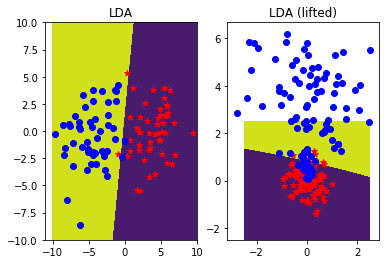

In [297]:
test_lda()

Accuracy: 0.740052


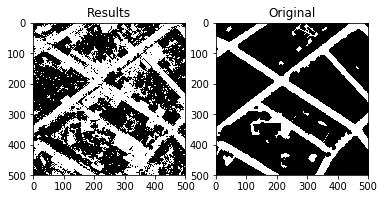

In [77]:
test_lda2() # streets type

Accuracy: 0.84952


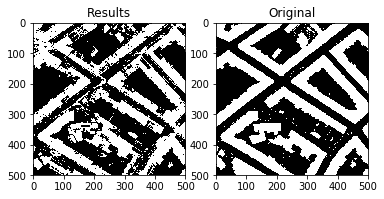

In [74]:
test_lda2() # buildings type

Accuracy: 0.965392


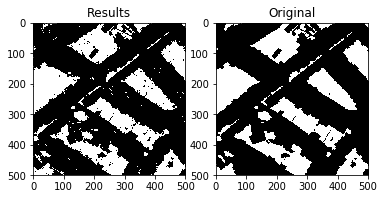

In [79]:
test_lda2() # vegetation type

## Report - Part 2: Linear Discriminant Analysis
For LDA, accuracy for the street type is `74.01%`. For buildings, it is `84.95%`. For vegetation, it is `96.54%`. As we can see, LDA also works best for vegetation type as KNN. And it is not robust as KNN who also works great for the other two types.

# Problem 3, 3 points
Logistic regression is a probabilistically principled classification method.
You are provided with the breast cancer dataset. You task is to implement function `ii_train_logress`
that uses __sciki-learn__ class `sklearn.linear_model.LogisticRegression` to fit a logistic regression model to the data. It should take
the same input arguments as train_lda and return the trained model. Also implement function `ii_test_logress`
that takes the trained model and input
features (in the common format) and returns the output of the logistic
regression model. Make sure you cget through the documentation for [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

You can use functions `test_logress` and `test_logress2` to test your
implementation.

Implement the function `classify_breast_cancer_with_logress` which using the functions `ii_train_logress` and
`ii_test_logress` can distinguish benign and malignant tumor. Use 75% of the dataset for training.

Note, that there are missing values in the dataset. You have to either:
* remove such examples
* interpolate missing values

in order to let python load the data for you with `pandas.read_csv('data/data.csv')`.

You can find description of the dataset in file _description.txt_.
Report how well logistic regression works for the breast cancer prediction (accuracy).

In [98]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

In [139]:
def test_logres():
    x_range = [-10, 10]
    X, Y = synthetic_lin()
    Y = Y * 2 - 1

    model = ii_train_logress(X, Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: (ii_test_logress(model, x) > 0.5) * 2 - 1
    )

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('Logistic Regression') 

    x_range = [-2.5, 2.5]

    X, Y = synthetic_nonlin()
    Y = Y * 2 - 1

    model = ii_train_logress(del_first_col(x2fx(X,'quadratic')), Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000,
        lambda x: 1 + (0.5 < ii_test_logress(model, del_first_col(x2fx(x, 'quadratic'))))
    )

    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('Logistic Regression (lifted)') 


def test_logres2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 3

    Y = (gt==true_class) * 2 - 1

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx, 1)

    model  = ii_train_logress(X[:used_train, :], Y[:used_train, :])
    results = ii_test_logress(model, X)
    results = results.reshape(sy, sx) > 0.5
    
    print('Accuracy:', model.score(X,Y)) # output accuracy
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')

In [125]:
def ii_train_logress(X, Y):
    
    Y = np.ravel(Y)
    
    clf = LogisticRegression(solver='newton-cg', multi_class='multinomial')
    
    clf.fit(X, Y)
    
    return clf

In [126]:
def ii_test_logress(clf, x):
    
    y_pred = clf.predict(x)
    
    return y_pred

In [258]:
def classify_breast_cancer_with_logress():
    
    # Read data.
    df = pd.read_csv('../data/data.csv')

    # Treat missing values.
    df = ii_proc_na(df)

    # Construct X and Y value.
    X, Y = ii_cre_xy(df)
    # Convert Y value
    Y[Y==4] = 1
    Y[Y==2] = -1
    
    # Train multiple times on random training data.
    accuracies = []
    
    for i in range(30):
        
        # Split data to training and test data.
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25)

        # Fit the classifier.
        clf = ii_train_logress(X_train, Y_train)
    
        accuracies.append(clf.score(X_test,Y_test))
        
    print("Mean accuracy:", np.mean(accuracies))

In [128]:
def ii_proc_na(df):
    
    # Judge if missing values exist.
    flag = df.isnull().all()==False

    if (flag.all() == True):
        print('There are no missing values.')

    # Treat missing values if existed.
    else:
        df_ind = df.columns
        df_naind = df_ind[df.isnull().any()]
        print(df.isnull().any())
        df_named = df[df_naind].mean().values
        print(df_named)

        # Replace NA with mean.
        df_fill = pd.Series(df_named, index=df_naind.tolist())
        df.fillna(df_fill, inplace = True)
        print(df.isnull().any())
        
    return df

In [143]:
def ii_cre_xy(df):
    
    # Tranfer dataframe to array.
    data = df.values

    # Construct X and Y values.
    X = data[:,1:9] # drop ID and class
    Y = data[:,10]
    
    return X, Y

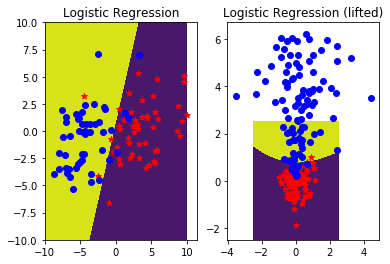

In [118]:
test_logres()

Accuracy: 0.799116


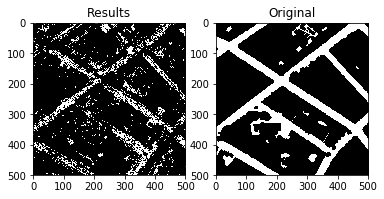

In [136]:
test_logres2() # streets type

Accuracy: 0.853248


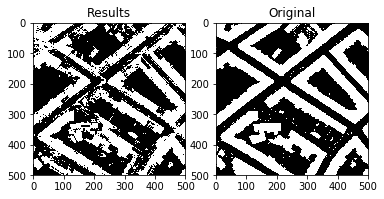

In [138]:
test_logres2() # buildings type

Accuracy: 0.968224


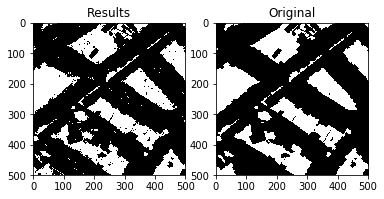

In [140]:
test_logres2() # vegetation type

In [257]:
classify_breast_cancer_with_logress()

There are no missing values.
Mean accuracy: 0.9662768031189082


## Report - Part 3: Logistic regression
**You can find description of the dataset in file description.txt. Report how well logistic regression works for the breast cancer prediction (accuracy).**

For Logistic regression, accuracy for the street type is `79.91%`. For buildings, it is `85.32%`. For vegetation, it is `96.82%`. As we can see, Logistic regression also works best for vegetation type as KNN and LDA. And it is similar to LDA, that it does not work very well on the other two types. But it outperforms than LDA for each type.

For the task to predict breast cancer, we need to treat missing values either by direct deletion or replacement with mean values. While in the experiment, as checked, there are no missing values. Normalization should be used afterward to have a unified scale on all features. As observed from description using `.describe()`, all attributes are of the same range from 1 to 10, which do not need normalization. Since splitting the data is a random process, we looped this same step for 30 times to train and fit the data and get an average accuracy. So Logistic regression can predict breast cancer with mean accuracy `96.63%`.

# Problem 4, 2 Points

Classification using random trees and forests is currently very popular
thanks to its efficiency and flexibility.
Implement function `ii_train_tree` that uses sklearn to train a decision tree. The function should use the same
input arguments as the previous training functions, but note that the tree
classifier can handle more than two classes, so this time the input is not
constrained to -1 or 1 (you do not need to handle this, this is done
automatically by the classifier). The function returns the trained decision
tree. Also implement function `ii_test_tree` that takes the trained
decision tree and input features (in the common format) and returns the
prediction made by the tree (search the documentation of sklearn for details.

You can use functions `test_tree` and `test_tree2` to test your
implementation and generate results for the report.

Implement the function `classify_breast_cancer_with_tree` which using the functions `ii_train_tree` and
`ii_test_tree` can distinguish benign and malignant tumor. Use 75% of the dataset for training.

In [276]:
from sklearn.tree import DecisionTreeClassifier

In [285]:
def test_tree():
    x_range = [-10, 10]

    X, Y = synthetic_lin()
    Y = Y * 2 - 1

    model = ii_train_tree(X, Y)
    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_tree(model, x)
    )

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('Tree') 

    x_range = [-2.5, 2.5]
    X, Y = synthetic_nonlin()
    Y = Y * 2 - 1

    model = ii_train_tree(X,Y)
    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_tree(model, x)
    )

    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('Tree')

    from sklearn.externals.six import StringIO  
    from IPython.display import Image  
    from sklearn.tree import export_graphviz
    import pydotplus
    
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph.create_png()


def test_tree2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 3

    Y = gt

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)

    tree = ii_train_tree(X[:used_train, :], Y[:used_train])

    results = ii_test_tree(tree, X)

    results = results.reshape(sy, sx)
    
    print('Accuracy:', metrics.accuracy_score(Y, results.reshape(sy*sx))) # output accuracy
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')

In [279]:
def ii_train_tree(X, Y):
    
    clf = DecisionTreeClassifier()
       
    clf.fit(X,Y)
    
    return clf

In [222]:
def ii_test_tree(clf, X):
    
    y_pred = clf.predict(X)
    
    return y_pred

In [254]:
def classify_breast_cancer_with_tree():
    
    # Read data.
    df = pd.read_csv('../data/data.csv')

    # Treat missing values.
    df = ii_proc_na(df)

    # Construct X and Y value.
    X, Y = ii_cre_xy(df)
 
    # Train multiple times on random training data.
    accuracies = []
    
    for i in range(30):
    
        # Split data to training and test data.
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25)

        # Fit the classifier.
        clf = ii_train_tree(X_train, Y_train)
    
        accuracies.append(clf.score(X_test,Y_test))
        
    print("Mean accuracy:", np.mean(accuracies))

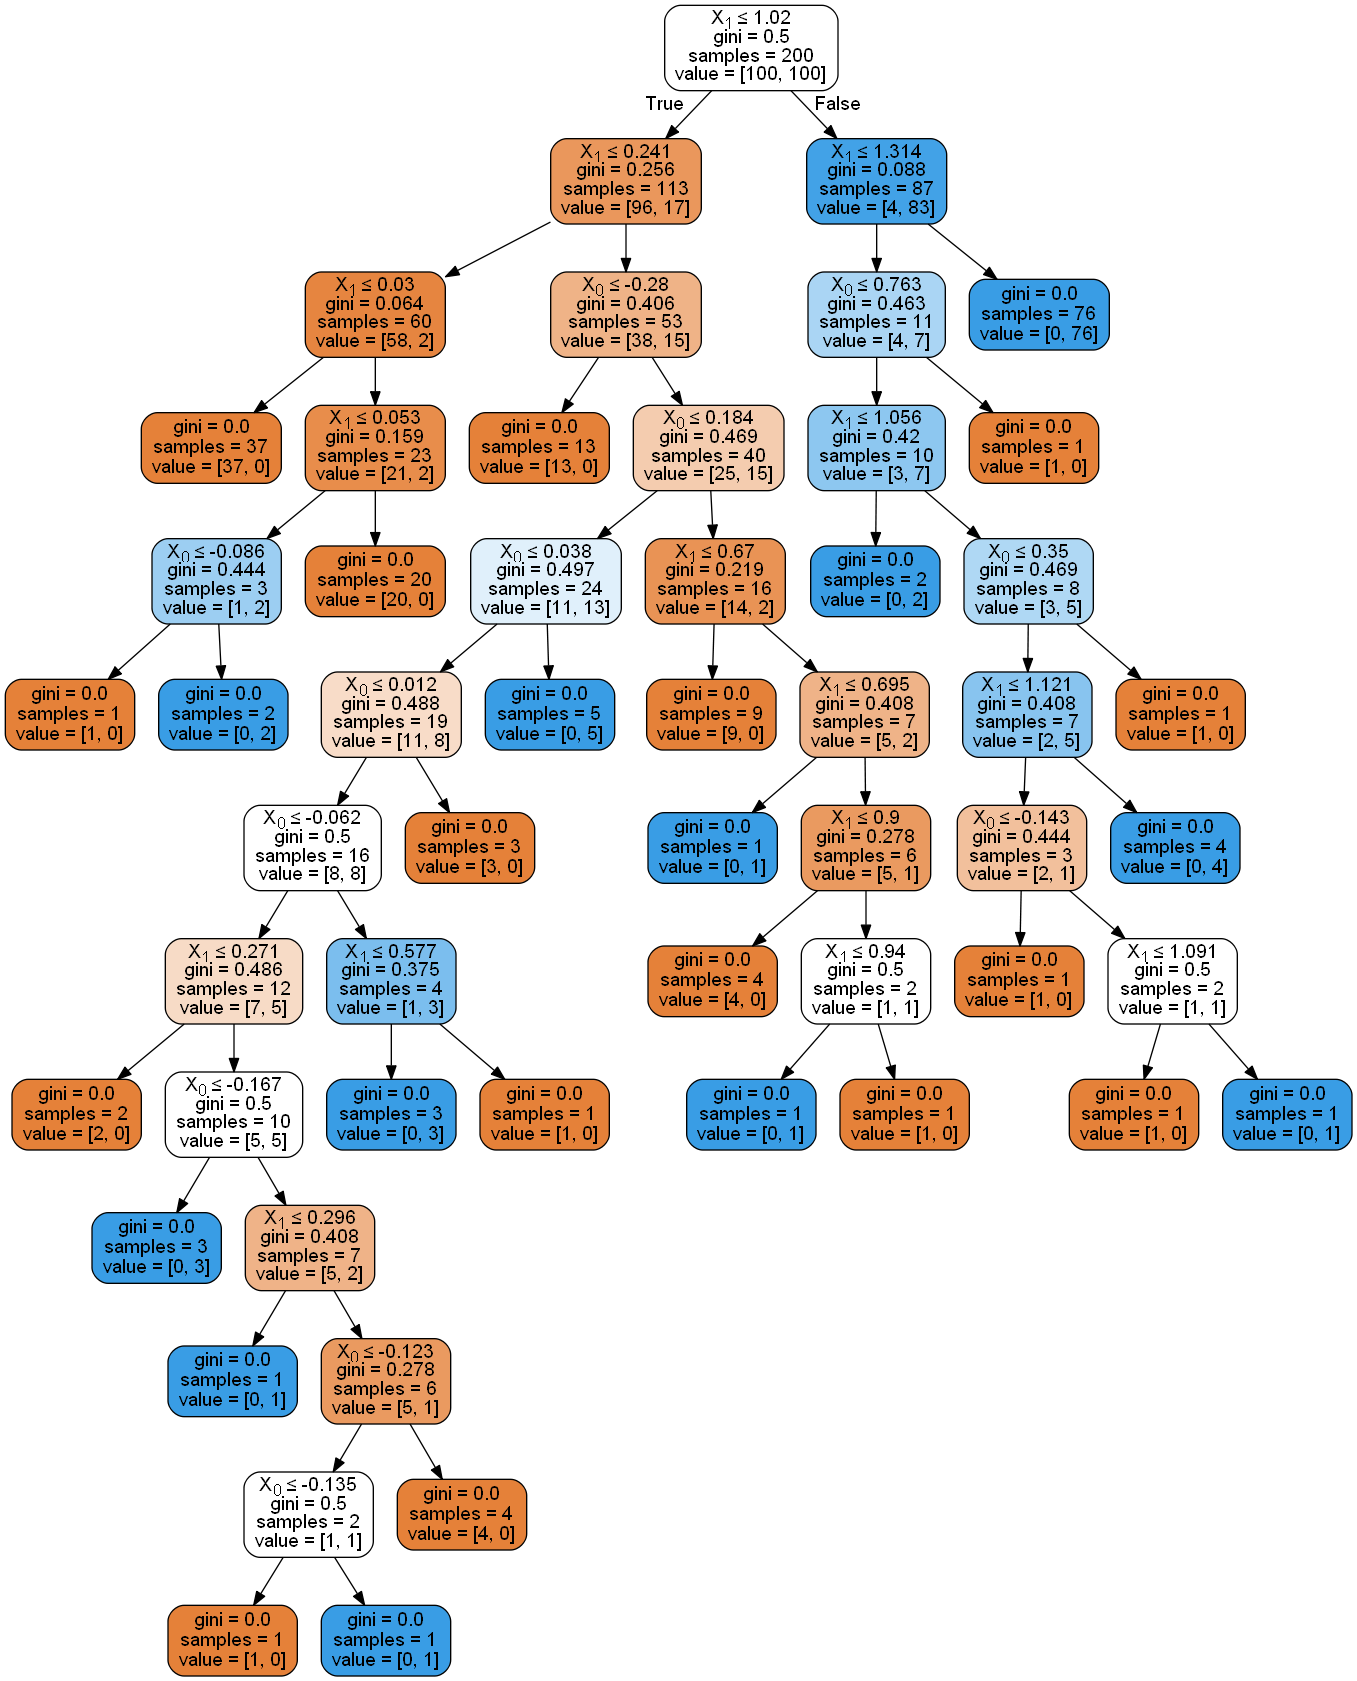

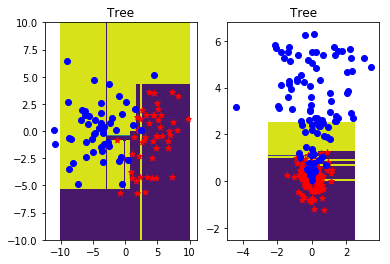

In [281]:
from IPython.display import Image
Image(test_tree())

Accuracy: 0.842648


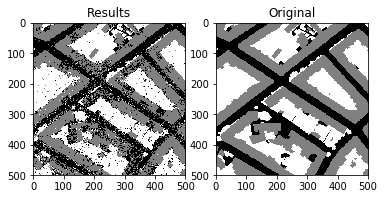

In [282]:
test_tree2() # streets type

Accuracy: 0.842604


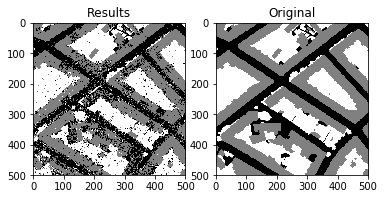

In [284]:
test_tree2() # buildings type

Accuracy: 0.842484


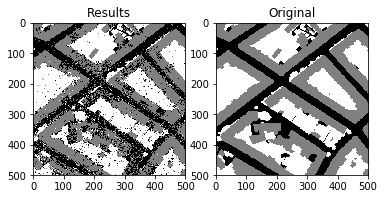

In [286]:
test_tree2() # vegetation type

In [287]:
classify_breast_cancer_with_tree()

There are no missing values.
Mean accuracy of breast cancer: 0.948343079922027


## Report - Part 4: Decision tree

For the decision tree, accuracy for the street type is `84.26%`. For buildings, it is `84.26%`. For vegetation, it is `84.25%`. The decision tree in the experiment gives similar accuracies for all three types. For the street type, it works better than both LDA and Logistic regression. The above three methods work similarly to the building type. While the decision tree works worse for the vegetation type than all other methods. I think the result will be influenced by hyperparameters settings. We could use cross-validation as in the first subtask of KNN to choose the best hyperparameters to improve the performance. And the mean accuracy for the decision tree to predict breast cancer is `94.83%`.